<a href="https://colab.research.google.com/github/adigaikwad1/NewYorktaxipricepred/blob/main/NYTaxifare(ANN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
df1 = files.upload()


Saving NYCTaxiFares.csv to NYCTaxiFares.csv


In [5]:
df = files.upload()

Saving taxifare.csv to taxifare (1).csv


In [7]:
import pandas as pd
import io
d0 = pd.read_csv(io.BytesIO(df['taxifare.csv']))
d1 = pd.read_csv(io.BytesIO(df1['NYCTaxiFares.csv']))

In [8]:
d0.head() 

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [9]:
d0.shape

(120000, 8)

In [10]:
import datetime
pd.to_datetime(d0['pickup_datetime'])


0        2010-04-19 08:17:56+00:00
1        2010-04-17 15:43:53+00:00
2        2010-04-17 11:23:26+00:00
3        2010-04-11 21:25:03+00:00
4        2010-04-17 02:19:01+00:00
                    ...           
119995   2010-04-18 14:33:03+00:00
119996   2010-04-23 10:27:48+00:00
119997   2010-04-18 18:50:40+00:00
119998   2010-04-13 08:14:44+00:00
119999   2010-04-17 16:00:14+00:00
Name: pickup_datetime, Length: 120000, dtype: datetime64[ns, UTC]

In [11]:
d0['pickup_datetime'] = pd.to_datetime(d0['pickup_datetime'])-datetime.timedelta(hours=4)


In [12]:
d0['Year'] = d0['pickup_datetime'].dt.year
d0['Month'] = d0['pickup_datetime'].dt.month
d0['Days'] = d0['pickup_datetime'].dt.day
d0['Hours'] = d0['pickup_datetime'].dt.hour
d0['Minutes'] = d0['pickup_datetime'].dt.minute


In [13]:
import numpy as np
d0['mornornight'] = np.where(d0['Hours']<12,0,1)
# Adding one hot encoding kind of structure where if less than 12 hours "0" shows morning else "1" is night


In [14]:
d0.drop('pickup_datetime',axis=1,inplace=True)

In [15]:
d0['fare_class'].unique()

array([0, 1])

In [16]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
newdelhi=[28.6139,77.2090]
bangalore=[12.9716,77.5946]
newdelhi_in_radians = [radians(_) for _ in newdelhi]
bangalore_in_radians = [radians(_) for _ in bangalore]
result = haversine_distances([newdelhi_in_radians,bangalore_in_radians])

In [17]:
import numpy as np
def haversine(d0):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1 = np.radians(d0["pickup_latitude"])
    lat2 = np.radians(d0["pickup_longitude"])

    # haversine formula 
    dlat =np.radians(d0["dropoff_latitude"]-d0["pickup_latitude"]) 
    dlon = np.radians(d0["dropoff_longitude"]-d0["pickup_longitude"])
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


In [18]:
d0['Total_distance']=haversine(d0)

In [19]:
d0.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Days,Hours,Minutes,mornornight,Total_distance
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17,0,1.799143
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43,0,0.897284
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23,0,2.413730
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25,1,1.340764
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19,1,4.433896


In [20]:
d0.drop(["dropoff_latitude","dropoff_longitude","pickup_latitude","pickup_longitude"],axis=1,inplace=True)

In [21]:
X = d0.iloc[:,1:]
Y = d0.iloc[:,0]
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=100)

##Lets create an ANN
##Importing keras libraries and packages
!pip install tensorflow
!pip install keras


In [19]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU
from tensorflow.keras.layers import Dropout

In [23]:
X_train.head()

,fare_class,passenger_count,Year,Month,Days,Hours,Minutes,mornornight,Total_distance
40090,1,1,2010,4,12,16,17,1,3.045643
90425,0,2,2010,4,18,7,39,0,1.356115
63492,0,1,2010,4,11,18,53,1,3.762912
19581,1,1,2010,4,21,20,51,1,4.201143
39057,1,1,2010,4,14,16,46,1,6.651693


In [24]:
Y_train.head()

40090    17.7
90425     4.9
63492     8.1
19581    17.7
39057    15.3
Name: fare_amount, dtype: float64

In [25]:
X_train.shape[1]

9

In [ ]:
NN_model = Sequential()

#Input layer
NN_model.add(Dense(128, kernel_initializer='normal',input_dim=X_train.shape[1],activation='relu'))

#Hidden layer
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

#Output layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#compile the network
NN_model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mean_absolute_error'])
NN_model.summary()

#Fitting ANN to training set
model_history = NN_model.fit(X_train,Y_train,validation_split=0.33,batch_size=10,epochs=15)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
5628/5628 [==============================] - 21s 4ms/step - loss: 2.5364 - mean_absolute_error: 2.5364 - 

Model Evaluation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


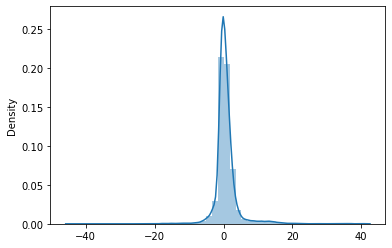

In [27]:
prediction = NN_model.predict(X_test)
import seaborn as sns
sns.distplot(Y_test.values.reshape(-1,1)-prediction)

In [28]:
from sklearn import metrics
print('MAE:',metrics.mean_absolute_error(Y_test,prediction))
print('MSE:',metrics.mean_squared_error(Y_test,prediction))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_test,prediction)))

MAE: 1.8568154969292219
MSE: 13.177438791202073
RMSE: 3.630074212905581
